In [0]:
!pip install unidecode

     |████████████████████████████████| 245kB 2.8MB/s 


In [0]:

import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('data/shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 5465394


In [0]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

d you offer


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, inputs, hidden):
        # input = [batch size]

        emb = self.embedding(inputs)

        #emb = [batch size, emb dim]

        emb=emb.unsqueeze(1)

        #emb = [batch size, 1, emb dim]

        output, hidden = self.gru(emb, hidden)

        #output = [batch size, 1, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]

        output = self.fc(output)

        #output = [batch size, 1, input dim]

        output = output.view(-1, self.input_size)

        #output = [batch size*1, input_dim] == [1, input dim]

        return output, hidden
        
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [0]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor).unsqueeze(1)

print(char_tensor('abcDEF'))

tensor([[10],
        [11],
        [12],
        [39],
        [40],
        [41]])


In [0]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [0]:
inp, tar = random_training_set()

In [0]:
inp

tensor([[56],
        [38],
        [43],
        [44],
        [50],
        [75],
        [94],
        [58],
        [17],
        [24]])

In [0]:
tar

tensor([[38],
        [43],
        [44],
        [50],
        [75],
        [94],
        [58],
        [17],
        [24],
        [28]])

In [0]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)[-1]

    return predicted

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

In [0]:

hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(decoder):,} trainable parameters')

The model has 80,700 trainable parameters


In [0]:
n_epochs = 2000
print_every = 100
plot_every = 10


start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 15s (100 5%) 2.3005]
Whut hand hat hat asat had thins boul sund archae mand thog hout so the dier
                 Auth ay  

 30s (200 10%) 2.1880]
WhI Fou lith bard hearth
   Buselo, amy gle.
    Thof mang,
   Buet for
  I Sat here tarecs at our you 

 45s (300 15%) 2.0582]
Wher eard.
   Hast state; knot as warn. Sit not entay chard bes, he be a that
     I be drose weart wa 

 0s (400 20%) 2.0936]
Whill bly be of and gos of my liven in live
           Tis in deand spe'n of whid lom, cuson candood s 

 15s (500 25%) 1.9056]
Whatheac! Bainteneds and god dods have atI I pleatotue a daughtseher.
                                 

 30s (600 30%) 2.1142]
Wheed.                                                                    ' Prould that ich our haves' 

 45s (700 35%) 1.9148]
Whe so welacue, warmpy of tons whount,
      Thave in heard senst not serve
   Unter recarrase, a beme 

 0s (800 40%) 2.3791]
Whing an that thou more an the with there to all but all the promever and warry'd of

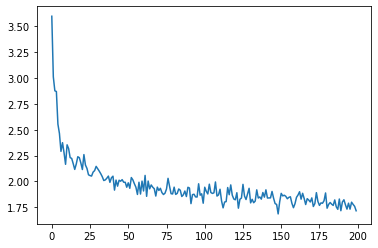

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)